**Mounting Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### **Importing Libraries**

In [0]:
import os, random, cv2, gc, warnings, math, matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
import tensorflow as tf 
try:
    from tensorflow.contrib import keras as keras
    print ('load keras from tensorflow package')
except:
    print ('update your tensorflow')
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers

from keras import backend as K
from keras.optimizers import Adam, SGD, Nadam
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dense
from copy import deepcopy
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion, OpticalDistortion
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import precision_recall_curve, auc
import albumentations as albu
from albumentations import torch as AT
from skimage.exposure import adjust_gamma
from keras.optimizers import Adam
plt.style.use('fivethirtyeight')



warnings.filterwarnings("ignore")
path        = '/content/drive/My Drive/CloudDataset/train/'


load keras from tensorflow package


Using TensorFlow backend.


### **Loading Training Dataset**

In [0]:
train_df = pd.read_csv(path+'train.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


### **Dataframe for Unique Image ID's with Number of Masks in Each Image**

In [0]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


,ImageId,hasMask
821,24dd99c.jpg,4.0
1885,562f80a.jpg,4.0
3260,944f10b.jpg,4.0
1872,55b539f.jpg,4.0
4464,cdf7242.jpg,4.0


### **Loading Test Dataset**

In [0]:
sub_df = pd.read_csv('/content/drive/My Drive/CloudDataset/sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

### **Utility Functions**

In [0]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
  

img_names_all = train_df['Image_Label'].apply(lambda x: x.split('_')[0]).unique()
len(img_names_all)

5546

### **Data Generator with Image Augumentation**

In [0]:
class DataGenerator(Sequence):
  def __init__(self,mode='fit',resize=True,batch_size=16,Shuffle=False,images_folder=path,
              augmentation=True,resize_height=128,resize_width=128,channels=3,images_list=None,
              image_csv=train_df,is_test=False,gamma=0.0):
    
    
    self.mode=mode
    self.resize=resize
    self.batch_size=batch_size
    self.shuffle=Shuffle
    self.images_folder=images_folder
    self.augmentation=augmentation
    self.height=resize_height
    self.width=resize_width
    self.channels=channels
    self.image_csv=image_csv
    self.is_test=is_test
    self.image_list=images_list
    if images_list is None:
      self.images_list = os.listdir(self.images_folder)
    else:
      self.images_list = deepcopy(images_list)
    self.len = len(self.image_list) // int(self.batch_size)
    self.labels={}
    self.on_epoch_start()
    self.gamma=gamma
    
    
  

        
  
  def __generate_X(self,img_list):
    X=np.empty((self.batch_size,self.height,self.width,self.channels))
    for i in range(0,self.batch_size):
      img_name=img_list[i]
      img=cv2.imread(self.images_folder+img_name)
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      if self.resize:
        img=cv2.resize(img,(self.width,self.height))
      if self.gamma is not None:
        img = adjust_gamma(img, gamma=self.gamma)
      X[i,:,:,:]=img/255.0
    return X
  
  def __generate_Y(self,img_list):
    Y=np.empty((self.batch_size,self.height,self.width,4))
    for i in range(0,self.batch_size):
      img=cv2.imread(self.images_folder+img_list[i])
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      for jdx, rle in enumerate((self.image_csv[self.image_csv['Image_Label'].apply(lambda x: x.split('_')[0]) == img_list[i]]['EncodedPixels'])):
        if pd.isnull(rle):
          
          mask=np.zeros((self.width,self.height))
        
        else:
          mask=rle2mask(rle,img.shape)
          mask=cv2.resize(mask,(self.width,self.height))
        
        Y[i,:,:,jdx]=mask
    
    return Y
      
  def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
  def __augment_batch(self, img_batch, masks_batch):
    for i in range(img_batch.shape[0]):
      img_batch[i, ], masks_batch[i, ] = self.__random_transform(
      img_batch[i, ], masks_batch[i, ])
        
    return img_batch, masks_batch
        
      
    
  def __len__(self):
        return self.len
    
  def get_labels(self):
      tr=pd.read_csv(path+self.image_csv)
      print (tr.shape)
      images_current = self.image_list[:self.len*self.batch_size]
      labels = [tr[tr['Image_Label'].apply(lambda x: x.split('_')[0]) == img]['EncodedPixels'] for img in images_current]
      return np.array(labels)
    
  def on_epoch_start(self):
    if self.shuffle:
      random.shuffle(self.image_list)
    
  def __getitem__(self,idx):
    indexes = self.images_list[idx*self.batch_size:(idx+1)*self.batch_size]

        
    #list_IDs_batch = [self.images_list[k] for k in indexes]
        
    X = self.__generate_X(indexes)
        
    if self.mode == 'fit':
      Y = self.__generate_Y(indexes)
      
      if self.augmentation:
        X, Y = self.__augment_batch(X, Y)
            
        return X, Y
        
    elif self.mode == 'predict':
      return X

    else:
      raise AttributeError('The mode parameter should be set to "fit" or "predict".')


    

### **Training and Validation Data Splitting**

In [0]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    mask_count_df['ImageId'].values.tolist(), random_state=2019, test_size=0.2
)

train_generator = DataGenerator(
    mode='fit',
    resize=True,
    Shuffle=True,
    images_folder=path,
    augmentation=True,
    images_list=train_idx,
    image_csv=train_df,
    gamma=0.8
)

val_generator = DataGenerator(
    mode='fit',
    resize=True,
    Shuffle=True,
    images_folder=path,
    augmentation=True,
    images_list=val_idx,
    image_csv=train_df,
    gamma=0.8
)

In [0]:
X,Y=train_generator[0]

### **Visualizing Some Training with Image Augumentation**

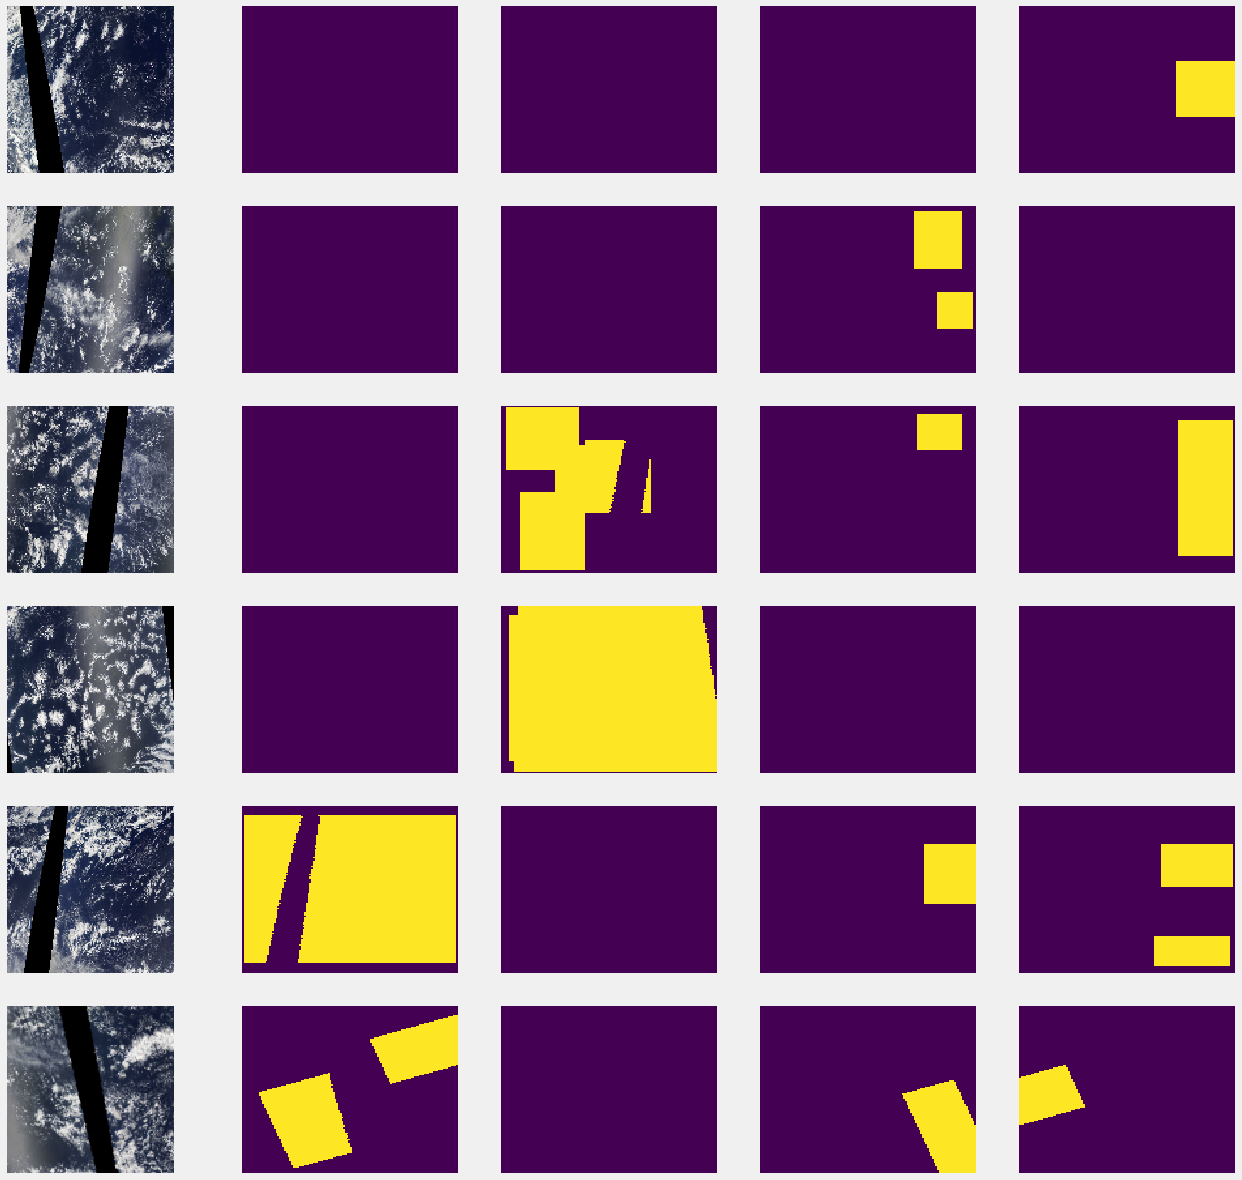

In [0]:
fig, axs = plt.subplots(6,5, figsize=(20, 20))
for j in range(6):
  for i in range(4):
    
    axs[j,0].imshow(X[j,:,:,:])
    axs[j,0].axis('off')
    axs[j,i+1].imshow(Y[j,:,:,i])
    axs[j,i+1].axis('off')
    axs[j,i+1].set_aspect('auto')
      
plt.show()

**Loading Unet Segementation trained on ImageNet Weights**

In [0]:
! pip install segmentation-models

### **Loss Function and Evaluation metric**

In [0]:
from keras.losses import binary_crossentropy
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

  
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
  

In [0]:
from segmentation_models import Unet
# LOAD UNET WITH PRETRAINING FROM IMAGENET
model = Unet('resnet18', encoder_weights='imagenet',input_shape=(128, 128, 3), classes=4, activation='sigmoid')
model.compile(optimizer=Adam(lr=0.01), loss=bce_dice_loss, metrics=[dice_coef])

### **Training and validation**

In [0]:
#checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
es = EarlyStopping(monitor='val_dice_coef', min_delta=0.0001, patience=5, verbose=1, mode='max', restore_best_weights=True)
#rlr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=2, min_lr=0.001,verbose=1, mode='max', min_delta=0.0001)

In [0]:
history=model.fit_generator(train_generator,validation_data=val_generator,
                            steps_per_epoch=16,
                            epochs=100,
                            callbacks=[es],
                            workers=1,
                            verbose=1)



Epoch 1/100
16/16 [==============================] - 895s 56s/step - loss: 1.2694 - dice_coef: 0.2188 - val_loss: 8.2963 - val_dice_coef: 0.2426
Epoch 2/100
16/16 [==============================] - 326s 20s/step - loss: 1.1825 - dice_coef: 0.2475 - val_loss: 5.9221 - val_dice_coef: 0.2058
Epoch 3/100
16/16 [==============================] - 326s 20s/step - loss: 1.1559 - dice_coef: 0.2758 - val_loss: 4.8141 - val_dice_coef: 0.1923
Epoch 4/100
16/16 [==============================] - 325s 20s/step - loss: 1.1293 - dice_coef: 0.2805 - val_loss: 1.4080 - val_dice_coef: 0.2424
Epoch 5/100
16/16 [==============================] - 326s 20s/step - loss: 1.1271 - dice_coef: 0.2825 - val_loss: 1.2186 - val_dice_coef: 0.2558
Epoch 6/100
16/16 [==============================] - 325s 20s/step - loss: 1.1233 - dice_coef: 0.2896 - val_loss: 1.3882 - val_dice_coef: 0.2532
Epoch 7/100
16/16 [==============================] - 325s 20s/step - loss: 1.1043 - dice_coef: 0.2941 - val_loss: 1.2449 - val_d

### **Loading trained model from drive with custom loss function**

In [0]:
# import keras.losses
# keras.losses.custom_loss = bce_dice_loss

In [0]:
# trained_model=load_model("/content/drive/My Drive/Cloud_Detection.h5",custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coef':dice_coef})

### **Saving trained model and weights to drive**

In [0]:
import pickle
with open('/content/first_model_history_dict', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/first_model_history_dict" '/content/drive/My Drive/'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
model.save('Cloud_Detection_best_model.h5')
model.save_weights('Cloud_Detection_best_model_weights.h5')
!cp "/content/Cloud_Detection_best_model.h5" '/content/drive/My Drive/'
!cp "/content/Cloud_Detection_best_model_weights.h5" '/content/drive/My Drive/'

### **Visualising Train & Val Loss & Dice Co-efficient**

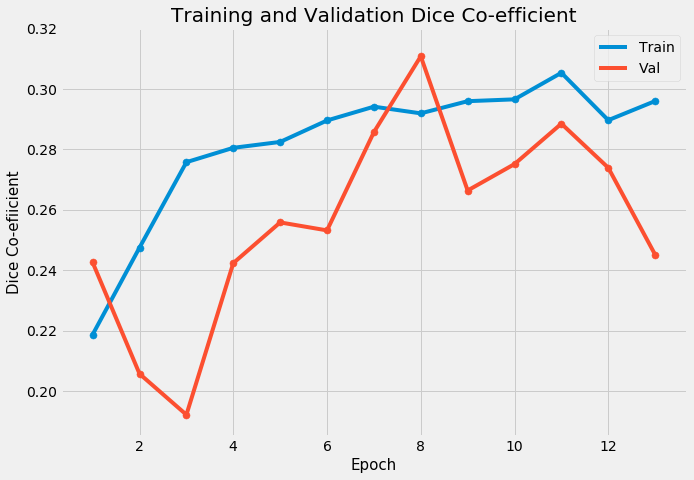

In [0]:
#plotting te dice coefficient
def plot_with_dots(ax, np_array):
    ax.scatter(list(range(1, len(np_array) + 1)), np_array, s=50)
    ax.plot(list(range(1, len(np_array) + 1)), np_array)
    
    
plt.figure(figsize=(10, 7))
plot_with_dots(plt, history.history['dice_coef'])
plot_with_dots(plt, history.history['val_dice_coef'])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Dice Co-efiicient', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation Dice Co-efficient', fontsize=20)
plt.savefig('pr_auc_hist.png')

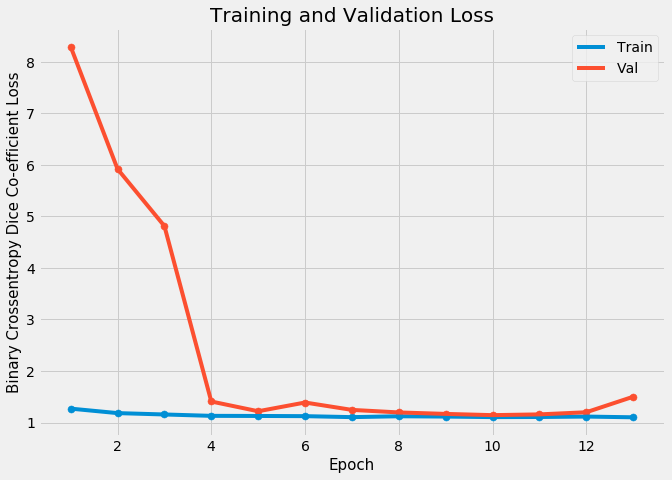

In [0]:
plt.figure(figsize=(10, 7))
plot_with_dots(plt, history.history['loss'])
plot_with_dots(plt, history.history['val_loss'])

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Binary Crossentropy Dice Co-efficient Loss', fontsize=15)
plt.legend(['Train', 'Val'])
plt.title('Training and Validation Loss', fontsize=20)
plt.savefig('loss_hist.png')

In [0]:
trained_model.evaluate_generator(val_generator,verbose=1)

69/69 [==============================] - 642s 9s/step


[1.1345690912094668, 0.292858006513637]

### **Prediction on test set**

In [0]:
%%time
test_img = []
path='/content/drive/My Drive/CloudDataset/'
path=os.path.join(path,'test/')
testfiles=os.listdir(path)
for fn in tqdm_notebook(testfiles):     
#         img =cv2.imread( path +fn )
#         img = cv2.resize(img,(img_width, img_height))       
        test_img.append(fn)
len(test_img)


CPU times: user 34.3 ms, sys: 1.06 ms, total: 35.4 ms
Wall time: 28 s


In [0]:
test_generator = DataGenerator(
    mode='predict',
    resize=True,
    batch_size=1,
    Shuffle=False,
    images_folder=path,
    augmentation=False,
    images_list=test_img,
    image_csv=test_imgs,
    gamma=0.0
)

In [0]:
%%time
predict = trained_model.predict_generator(test_generator,verbose=1)

3698/3698 [==============================] - 1768s 478ms/step
CPU times: user 14min 12s, sys: 34.6 s, total: 14min 46s
Wall time: 29min 29s


In [0]:
%%time
pred_rle = []
for img in tqdm_notebook(predict):      
    img = cv2.resize(img, (525, 350))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    for i in range(tmp.shape[-1]):
        pred_rle.append(mask2rle(tmp[:,:,i]))
len(pred_rle)


CPU times: user 56.3 s, sys: 2.64 s, total: 58.9 s
Wall time: 55.3 s


In [0]:
pred_rle[0]

'1 1065 1384 4 1389 25 1745 10 1757 6 2096 9 2109 3 2447 8 2459 3 2798 7 2808 4 3148 7 3158 4 3498 7 3508 4 3848 7 3857 5 4198 7 4207 5 4549 6 4557 6 4899 6 4906 7 5249 6 5257 6 5599 6 5607 6 5949 6 5957 7 6299 6 6307 7 6649 6 6657 7 6999 6 7007 6 7349 6 7358 5 7699 6 7709 3 8049 6 8059 3 8399 6 8409 4 8749 6 8759 4 9099 6 9109 4 9449 6 9459 4 9799 6 9809 3 10149 6 10160 1 10499 6 10510 1 10849 6 10860 1 11199 6 11210 1 11549 6 11560 1 11899 5 11910 2 12250 4 12260 2 12601 3 12610 1 12951 3 12960 1 13301 3 13310 1 13651 3 13660 1 14001 3 14010 1 14351 3 14360 1 14701 3 14709 2 15051 3 15059 2 15401 3 15409 3 15751 3 15759 3 16101 3 16109 3 16451 4 16459 3 16801 4 16809 3 17151 4 17159 3 17501 4 17508 4 17851 4 17858 5 18201 4 18208 5 18551 4 18558 5 18901 4 18908 5 19251 4 19258 5 19601 4 19608 6 19951 4 19958 6 20301 4 20308 6 20651 4 20658 6 21001 4 21008 6 21351 4 21358 6 21701 4 21708 6 22051 4 22058 6 22401 4 22408 6 22751 4 22758 6 23101 4 23108 6 23451 4 23458 6 23801 4 23808 6 

### **Submission of Result in Kaggle Format**

In [0]:

sub = pd.read_csv('/content/drive/My Drive/CloudDataset/sample_submission.csv', converters={'EncodedPixels': lambda e: ' '} )
sub['EncodedPixels'] = pred_rle
sub.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 1065 1384 4 1389 25 1745 10 1757 6 2096 9 21...
1,002f507.jpg_Flower,1 18 319 50 669 52 727 7 777 26 806 45 858 8 8...
2,002f507.jpg_Gravel,1 1769 1774 11 1790 4 1819 206 2037 81 2427 5 ...
3,002f507.jpg_Sugar,1 8 347 12 697 11 1047 10 1398 7 1748 7 2099 6...
4,0035ae9.jpg_Fish,1 1065 1384 4 1389 25 1745 10 1757 6 2096 9 21...


In [0]:
sub.to_csv('submission.csv', index=False)

In [0]:
!cp submission.csv "/content/drive/My Drive/CloudDataset/train_CSV"

In [0]:
sub.shape

(14792, 2)